<a href="https://colab.research.google.com/github/avladova/Frost-Heaving-and-Surfacing/blob/main/MDPI_Soil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.impute import MissingIndicator
from sklearn import preprocessing 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['source']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Load data

In [94]:
ID='1JweHYY03X9p8mU4TkMJhI6MUiqZziKMJaTqexgLawNc'
sheet_url="https://docs.google.com/spreadsheets/d/1JweHYY03X9p8mU4TkMJhI6MUiqZziKMJaTqexgLawNc/edit#gid=1744952440"
url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
raw=pd.read_csv(url_1)
print(raw.info())
raw.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   km           593 non-null    int64  
 1   Picket       593 non-null    int64  
 2   Rider, m     593 non-null    float64
 3   Depth, m     593 non-null    float64
 4   Power, m     593 non-null    float64
 5   Code         593 non-null    int64  
 6   Description  591 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 32.6+ KB
None


,km,Picket,"Rider, m","Depth, m","Power, m",Code,Description
61,341,3416,55.0,4.8,4.1,210,"Суглинок зеленовато-серый, пластичномерзлый, л..."
497,351,3517,87.0,0.8,0.8,931,"Торф светло-коричневый слаборазложившийся,t<0,..."
330,347,3471,56.0,12.0,0.6,307,Супесь пластичная
381,347,3479,58.7,10.7,0.9,456,Песок пылеватый насыщенный водой
562,358,3581,45.0,0.2,0.2,60,ПРС


# Preliminary analysis

In [95]:
raw['Description'].describe()
raw['Route']=raw.Picket+raw['Rider, m']/100

## Correlation

In [96]:
raw.corr()

,km,Picket,"Rider, m","Depth, m","Power, m",Code,Route
km,1.000000,0.997902,-0.017555,-0.030143,-0.072932,-0.256289,0.997892
Picket,0.997902,1.000000,-0.018590,-0.030614,-0.073708,-0.255911,0.999984
"Rider, m",-0.017555,-0.018590,1.000000,0.005451,-0.073074,0.023207,-0.012955
"Depth, m",-0.030143,-0.030614,0.005451,1.000000,0.469286,-0.220055,-0.030586
"Power, m",-0.072932,-0.073708,-0.073074,0.469286,1.000000,-0.020978,-0.074127
Code,-0.256289,-0.255911,0.023207,-0.220055,-0.020978,1.000000,-0.255803
Route,0.997892,0.999984,-0.012955,-0.030586,-0.074127,-0.255803,1.000000


In [97]:
raw[raw.isna().any(axis=1)]

,km,Picket,"Rider, m","Depth, m","Power, m",Code,Description,Route
467,350,3507,72.67,0.0,0.0,0,NaN,3507.7267
473,350,3509,24.00,0.0,0.0,0,NaN,3509.2400


In [98]:
miss=raw.copy().drop(columns='Rider, m')
miss[miss.isin([0]).any(axis=1)]

,km,Picket,"Depth, m","Power, m",Code,Description,Route
436,349,3495,0.0,0.0,0,нет данных,3495.0000
456,350,3500,0.0,0.0,0,нет данных,3500.5640
467,350,3507,0.0,0.0,0,NaN,3507.7267
473,350,3509,0.0,0.0,0,NaN,3509.2400


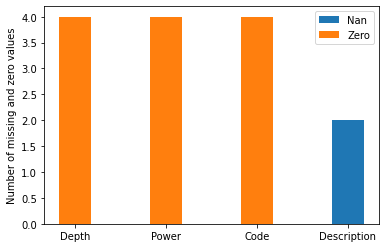

In [99]:
cols=['Depth, m', 'Power, m', 'Code', 'Description']
fig, ax = plt.subplots()
labels = ["Depth","Power","Code","Description"]
width = 0.35       # the width of the bars
ax.bar(labels, raw.loc[:, cols].isnull().sum(), width, label='Nan')
ax.bar(labels, raw.loc[:, cols].isin([0]).sum(), width, label='Zero')
plt.ylabel("Number of missing and zero values")
ax.legend()
plt.show()

## Replace NaN with Zeros

In [100]:
source=raw.copy()
source.replace(np.nan, 0, inplace=True)
source.replace('нет данных', 0, inplace=True)
source.loc[(source['Code'] == 0.0)|(source['Depth, m']==0.0)|(source['Power, m']==0.0)]#|(source['Route']==0.0)]

,km,Picket,"Rider, m","Depth, m","Power, m",Code,Description,Route
436,349,3495,0.00,0.0,0.0,0,0,3495.0000
456,350,3500,56.40,0.0,0.0,0,0,3500.5640
467,350,3507,72.67,0.0,0.0,0,0,3507.7267
473,350,3509,24.00,0.0,0.0,0,0,3509.2400


In [101]:
source['Code'] = source['Code'].astype('int64');
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   km           593 non-null    int64  
 1   Picket       593 non-null    int64  
 2   Rider, m     593 non-null    float64
 3   Depth, m     593 non-null    float64
 4   Power, m     593 non-null    float64
 5   Code         593 non-null    int64  
 6   Description  593 non-null    object 
 7   Route        593 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 37.2+ KB


#Feature engineering

In [102]:
df=source.copy()
df['Route']=df.Picket+df['Rider, m']/100
replacements = {
   'Description': {
      r'(Почвенно-растительный слой|прс)':'ПРС',
}
}
df.replace(replacements, regex=True, inplace=True)

In [103]:
keywords = ['твердомерзлый','пластичномерзлый','твердомерзлая','пластичномерзлая', 'льдистый', 'льдистая', 'лед','крио']
df['Frozen']=df['Description'].apply(lambda x: any([k in x for k in keywords]) if type(x)==str else np.nan)

In [104]:
keywords = ['водой','вода','Вода', 'водо', ' текучая']
df['Water']=df['Description'].apply(lambda x: any([k in x for k in keywords]) if type(x)==str else np.nan)

In [105]:
keywords = ['текучепластичный','текучепластичная',' пластичная', 'мягкопластичный','среднепластичная']
df['Plasticity']=df['Description'].apply(lambda x: any([k in x for k in keywords]) if type(x)==str else np.nan)

In [106]:
df['Soil type'] = pd.cut(df['Code'],bins=[0,60,80, 100, 200, 300, 400, 900, 1000], labels=['Fertile','Moss','Water','Clay','Loam','Sandy loam','Sand','Peat'])
df['Frozen depth']=pd.cut(df['Depth, m'],bins=[0,7,30], labels=[True,False])
df['Code'] = df['Code'].astype('int64');

In [107]:
df['Deformation']=df['Soil type'].replace(['Fertile','Moss','Water','Clay','Loam','Sandy loam','Sand','Peat'], [0,0,1,0.06,0.111,0.106,0.102,0])

In [108]:
df['Words'] = df['Description'].str.split().str.len()
df['Characters'] = df['Description'].str.len()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   km            593 non-null    int64   
 1   Picket        593 non-null    int64   
 2   Rider, m      593 non-null    float64 
 3   Depth, m      593 non-null    float64 
 4   Power, m      593 non-null    float64 
 5   Code          593 non-null    int64   
 6   Description   593 non-null    object  
 7   Route         593 non-null    float64 
 8   Frozen        589 non-null    object  
 9   Water         589 non-null    object  
 10  Plasticity    589 non-null    object  
 11  Soil type     589 non-null    category
 12  Frozen depth  589 non-null    category
 13  Deformation   589 non-null    float64 
 14  Words         589 non-null    float64 
 15  Characters    589 non-null    float64 
dtypes: category(2), float64(7), int64(3), object(4)
memory usage: 66.6+ KB


## Results of feature engineering

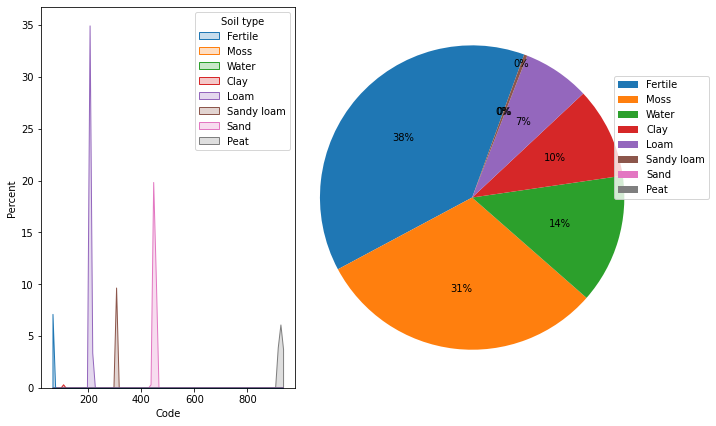

In [109]:
fig1, ax = plt.subplots(1,2, figsize=(10,7)) 
#hist
ax[0]=sns.histplot(data=df, x='Code', element='poly', hue="Soil type",stat="percent", ax=ax[0], binwidth=10)
#pie
ax[1]=plt.pie(df['Soil type'].value_counts(),
            autopct='%1.0f%%',
            startangle=70,
            explode = (0, 0, 0, 0,0,0,0,0.5),
            radius=1.5)
labels=['Fertile','Moss','Water','Clay','Loam','Sandy loam','Sand','Peat']
plt.legend(labels=labels, bbox_to_anchor=(1.04, 1), loc='upper left')

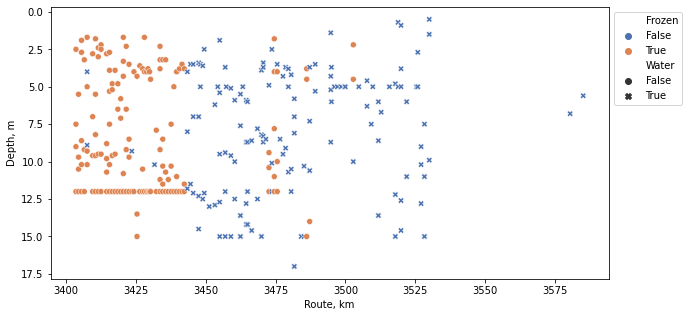

In [110]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x='Route', y='Depth, m',
                hue='Frozen', 
                style='Water',
                data=df.loc[(df['Frozen'] == True) | (df['Water'] == True)],
                palette="deep",
                ax=ax,
                )
ax.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Route, km")
plt.ylabel("Depth, m")
#plt.legend(loc='upper right')
plt.gca().invert_yaxis()

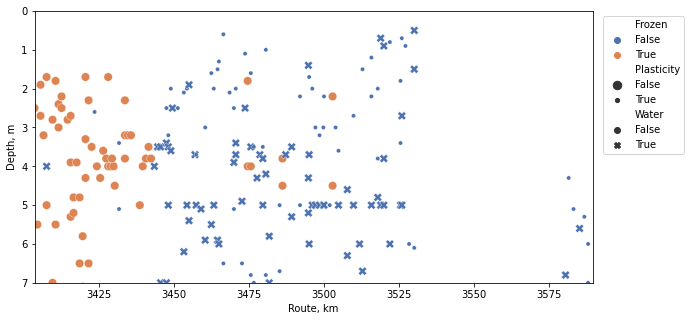

In [111]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x='Route', y='Depth, m',
                hue='Frozen', 
                style='Water',
                size='Plasticity',
                data=df.loc[(df['Frozen'] == True) | (df['Water'] == True) | (df['Plasticity'] == True)],
                palette="deep",
                ax=ax,
                ) 
ax.set_xlim(df.Route.min(), df.Route.max())
ax.set_ylim(df['Depth, m'].min(), df['Depth, m'].max()-10)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xlabel("Route, km")
plt.ylabel("Depth, m")
plt.gca().invert_yaxis()

# Restore zeros

In [112]:
res=df.copy() 
res.drop(columns='Description', inplace=True)
res.sample(2)
res['Code'].replace(0, np.nan, inplace=True)
res['Depth, m'].replace(0.0, np.nan, inplace=True)
res['Power, m'].replace(0.0, np.nan, inplace=True)
res.sample(2)

,km,Picket,"Rider, m","Depth, m","Power, m",Code,Route,Frozen,Water,Plasticity,Soil type,Frozen depth,Deformation,Words,Characters
219,344,3449,48.4,12.1,9.6,456.0,3449.484,False,True,False,Sand,False,0.102,4.0,32.0
328,347,3471,56.0,8.5,6.9,446.0,3471.560,False,True,False,Sand,False,0.102,4.0,29.0


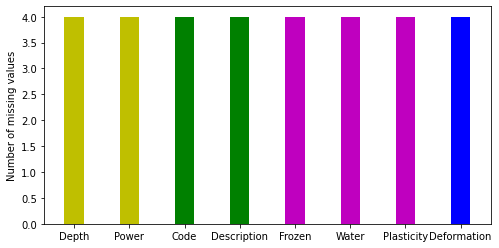

In [113]:
(res==0).sum()
cols=['Depth, m', 'Power, m', 'Code', 'Soil type', 'Frozen', 'Water','Plasticity', 'Deformation']
fig, ax = plt.subplots(figsize=(8,4))
labels = ["Depth","Power","Code","Description", 'Frozen', 'Water','Plasticity', 'Deformation']
width = 0.35       # the width of the bars
ax.bar(labels, res.loc[:, cols].isna().sum(), width, color=['y','y','g','g','m','m','m','b'])
plt.ylabel("Number of missing values")
plt.show()

In [114]:
res=res.replace({True: 1, False: 0})
res.drop(columns=['Soil type'], inplace=True)

In [115]:
res['Heaving']=(res['Frozen']+res['Water'])+res['Frozen depth']
res[res['Heaving']>1]

,km,Picket,"Rider, m","Depth, m","Power, m",Code,Route,Frozen,Water,Plasticity,Frozen depth,Deformation,Words,Characters,Heaving
0,340,3403,57.00,2.5,1.9,929.0,3403.5700,1.0,0.0,0.0,1.0,0.000,3.0,41.0,2.0
5,340,3404,50.00,5.5,3.0,448.0,3404.5000,1.0,0.0,0.0,1.0,0.102,3.0,26.0,2.0
10,340,3405,56.00,1.9,1.1,929.0,3405.5600,1.0,0.0,0.0,1.0,0.000,3.0,41.0,2.0
11,340,3405,56.00,2.7,0.8,210.0,3405.5600,1.0,0.0,0.0,1.0,0.111,6.0,84.0,2.0
16,340,3406,56.00,3.2,2.3,210.0,3406.5600,1.0,0.0,0.0,1.0,0.111,6.0,84.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,352,3525,88.24,5.0,2.3,306.0,3525.8824,0.0,1.0,0.0,1.0,0.106,2.0,14.0,2.0
554,353,3530,0.00,0.5,0.3,446.0,3530.0000,0.0,1.0,0.0,1.0,0.102,4.0,29.0,2.0
555,353,3530,0.00,1.5,1.0,306.0,3530.0000,0.0,1.0,0.0,1.0,0.106,2.0,14.0,2.0
560,358,3580,40.00,6.8,5.9,446.0,3580.4000,0.0,1.0,0.0,1.0,0.102,4.0,29.0,2.0


In [116]:
cols = res.columns
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(res[cols])
scaled_data

array([[0.        , 0.        , 0.59375   , ..., 0.4       , 0.4691358 ,
        1.        ],
       [0.        , 0.        , 0.59375   , ..., 0.4       , 0.28395062,
        0.5       ],
       [0.        , 0.        , 0.59375   , ..., 0.2       , 0.24691358,
        0.5       ],
       ...,
       [1.        , 1.        , 0.41666667, ..., 0.6       , 0.39506173,
        0.        ],
       [1.        , 1.        , 0.41666667, ..., 0.2       , 0.17283951,
        0.        ],
       [1.        , 1.        , 0.41666667, ..., 0.6       , 0.39506173,
        0.        ]])

In [117]:
X=res.copy()
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit(scaled_data)
X1 = imputer.transform(scaled_data)
df2 = pd.DataFrame(scaler.inverse_transform(X1),columns = X.columns) 
df2['Code'] = df2['Code'].astype('int64')
df2.sample(3)

,km,Picket,"Rider, m","Depth, m","Power, m",Code,Route,Frozen,Water,Plasticity,Frozen depth,Deformation,Words,Characters,Heaving
265,346.0,3462.0,43.2,1.6,1.5,307,3462.432,0.0,0.0,1.0,1.0,0.106,2.0,17.0,1.0
292,346.0,3464.0,96.0,15.0,0.8,204,3464.960,0.0,0.0,1.0,0.0,0.111,2.0,24.0,0.0
1,340.0,3403.0,57.0,7.5,5.0,448,3403.570,1.0,0.0,0.0,0.0,0.102,3.0,26.0,1.0


In [118]:
#Errors of imputing
df2['Soil type']=pd.cut(df2['Code'],bins=[0,60,80, 100, 200, 300, 400, 900, 1000], labels=['Fertile','Moss','Water','Clay','Loam','Sandy loam','Sand','Peat'])
df2.loc[(df2['Plasticity'] == 0.5)|(df2['Frozen']==0.5)|(df2['Water']==0.5)|(df2['Frozen depth']==0.5)]

,km,Picket,"Rider, m","Depth, m","Power, m",Code,Route,Frozen,Water,Plasticity,Frozen depth,Deformation,Words,Characters,Heaving,Soil type
436,349.0,3495.0,0.0,2.0,1.15,251,3495.000,0.0,0.5,0.0,1.0,0.051,3.0,26.0,1.5,Loam
456,350.0,3500.0,56.4,2.8,1.20,688,3500.564,0.0,0.5,0.0,1.0,0.051,4.0,42.5,1.5,Sand


## Results of zeros & omissions restoration

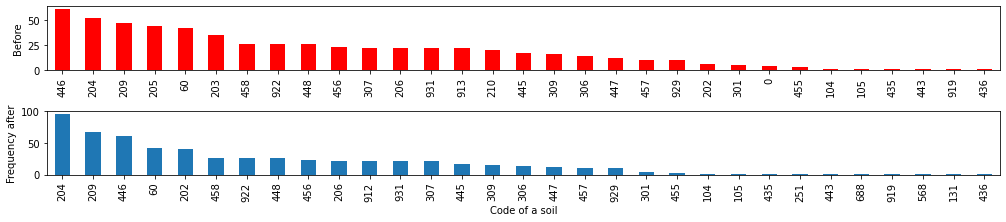

In [119]:
fig1, ax = plt.subplots(2, figsize=(14,3)) # 1 row, 2 columns
plt.subplot(2,1,1)
ax[1]=source['Code'].value_counts().plot.bar(color='Red')
plt.ylabel('Before')
plt.subplot(2,1,2)
ax[0]=df2['Code'].value_counts().plot.bar()
fig1.tight_layout()
plt.xlabel('Code of a soil')
plt.ylabel('Frequency after')
plt.show()

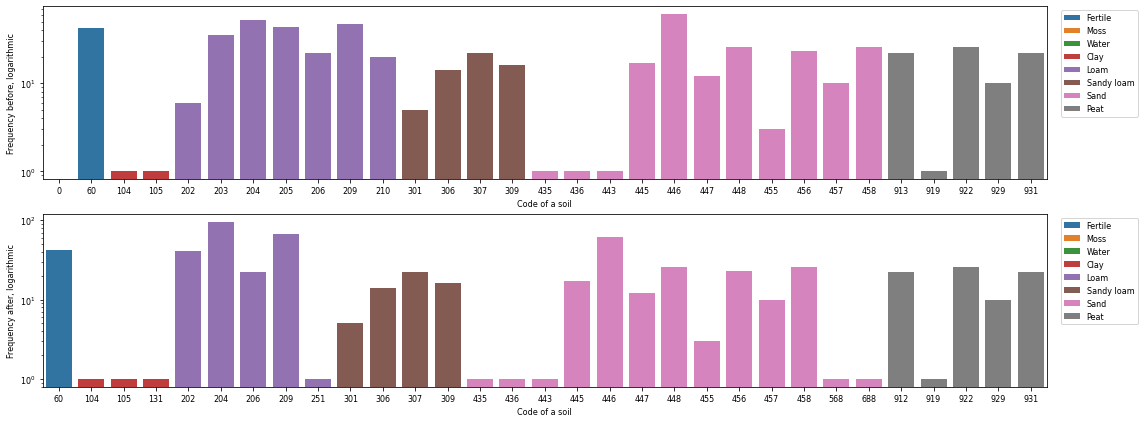

In [120]:
plt.rcParams['font.size'] = 8
plt.figure(figsize=(18,7))
plt.subplot(2,1,1)
sns.countplot(x='Code', data=df, hue='Soil type', log=True, dodge=False)
plt.xlabel('Code of a soil')
plt.ylabel('Frequency before, logarithmic')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.subplot(2,1,2)
sns.countplot(x='Code', data=df2, hue='Soil type', log=True, dodge=False)
plt.xlabel('Code of a soil')
plt.ylabel('Frequency after, logarithmic')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

# Site ranking

In [121]:
df2['Range']=df2['Deformation']*df2['Heaving']
df2.sort_values(by='Range', ascending=False, inplace=True)
df2['Dangerous'] = pd.cut(df2['Range'],bins=[0, 0.1, 0.2, 1.4, 2.5], labels=[0,1,2,3])
df2[(df2['Dangerous']==3)|(df2['Dangerous']==2)]

,km,Picket,"Rider, m","Depth, m","Power, m",Code,Route,Frozen,Water,Plasticity,Frozen depth,Deformation,Words,Characters,Heaving,Soil type,Range,Dangerous
90,342.0,3422.0,57.0,3.5,3.0,209,3422.570,1.0,0.0,0.0,1.0,0.111,2.0,25.0,2.0,Loam,0.222,2
40,341.0,3411.0,56.0,3.0,0.6,209,3411.560,1.0,0.0,0.0,1.0,0.111,6.0,84.0,2.0,Loam,0.222,2
70,341.0,3418.0,57.0,4.8,4.1,209,3418.570,1.0,0.0,0.0,1.0,0.111,5.0,64.0,2.0,Loam,0.222,2
151,343.0,3435.0,67.0,3.2,2.7,209,3435.670,1.0,0.0,0.0,1.0,0.111,2.0,25.0,2.0,Loam,0.222,2
460,350.0,3502.0,82.6,4.5,2.3,209,3502.826,1.0,0.0,0.0,1.0,0.111,5.0,64.0,2.0,Loam,0.222,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,349.0,3499.0,95.2,5.0,2.8,446,3499.952,0.0,1.0,0.0,1.0,0.102,4.0,29.0,2.0,Sand,0.204,2
5,340.0,3404.0,50.0,5.5,3.0,448,3404.500,1.0,0.0,0.0,1.0,0.102,3.0,26.0,2.0,Sand,0.204,2
23,340.0,3407.0,57.0,5.0,4.5,448,3407.570,1.0,0.0,0.0,1.0,0.102,3.0,26.0,2.0,Sand,0.204,2
86,342.0,3421.0,56.0,6.5,4.2,448,3421.560,1.0,0.0,0.0,1.0,0.102,3.0,26.0,2.0,Sand,0.204,2


In [122]:
df3=df2.groupby(['Route'])['Range'].sum().to_frame()
df3.sort_values(by='Range', ascending=False, inplace=True)
df3['Dangerous'] = pd.cut(df3['Range'],bins=[0, 0.1, 0.2, 1.4, 2.5], labels=[0,1,2,3])

In [123]:
# reshape the long form data into a wide form
dfp = df3.pivot( columns='Dangerous', values='Range')

## Results of ranking

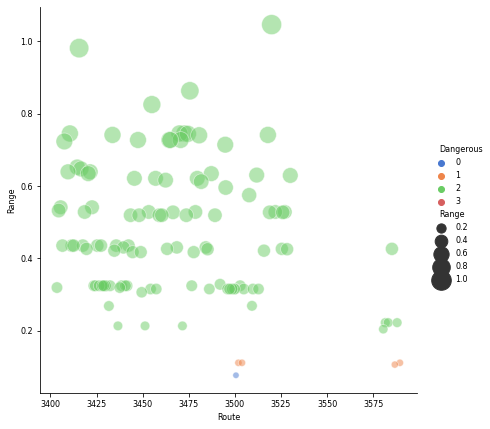

In [124]:
g=sns.relplot(data=df3, x="Route", y="Range", hue="Dangerous", size="Range",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6)
g.set_titles("")
g.tight_layout()

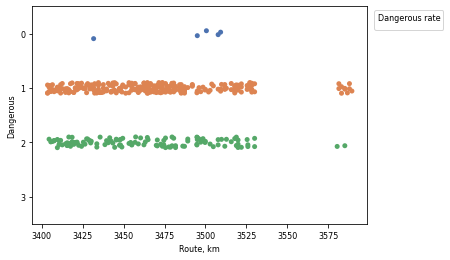

In [125]:
sns.stripplot(data=df2, x="Route", y="Dangerous", palette="deep")
plt.xlabel('Route, km')
plt.legend(title="Dangerous rate", bbox_to_anchor=(1.01, 1), loc='upper left')

# Distributions

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


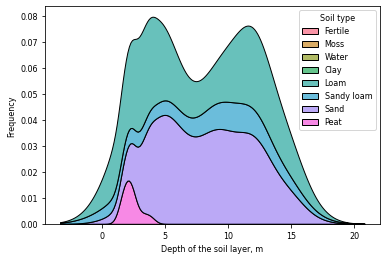

In [126]:
sns.kdeplot(data=df.loc[(df['Frozen'] == True) | (df['Water'] == True) | (df['Plasticity'] == True)], 
            x="Depth, m", multiple="stack", palette='husl', hue="Soil type", legend=True)
# Setting the X and Y Label
plt.xlabel('Depth of the soil layer, m')
plt.ylabel('Frequency')
plt.show()

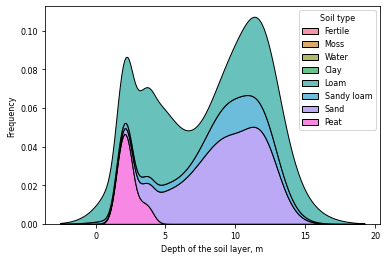

In [127]:
sns.kdeplot(data=df.loc[(df['Frozen'] == True)], 
            x="Depth, m", multiple="stack", palette='husl', hue="Soil type", legend=True)
# Setting the X and Y Label
plt.xlabel('Depth of the soil layer, m')
plt.ylabel('Frequency')
plt.show()

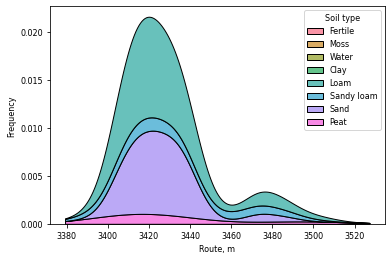

In [128]:
sns.kdeplot(data=df.loc[(df['Frozen'] == True)], 
            x="Route", multiple="stack", palette='husl', hue="Soil type", legend=True)
# Setting the X and Y Label
plt.xlabel('Route, m')
plt.ylabel('Frequency')
plt.show()

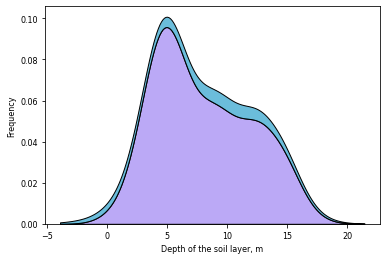

In [129]:
sns.kdeplot(data=df.loc[(df['Water'] == True)], 
            x="Depth, m", multiple="stack", palette='husl', hue="Soil type", legend=False)
# Setting the X and Y Label
plt.xlabel('Depth of the soil layer, m')
#plt.rcParams["figure.figsize"]=(5, 7)
plt.ylabel('Frequency')
plt.show()

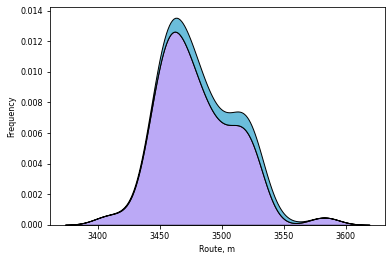

In [130]:
sns.kdeplot(data=df.loc[(df['Water'] == True)], 
            x="Route", multiple="stack", palette='husl', hue="Soil type", legend=False)
# Setting the X and Y Label
plt.xlabel('Route, m')
#plt.rcParams["figure.figsize"]=(5, 7)
plt.ylabel('Frequency')
plt.show()

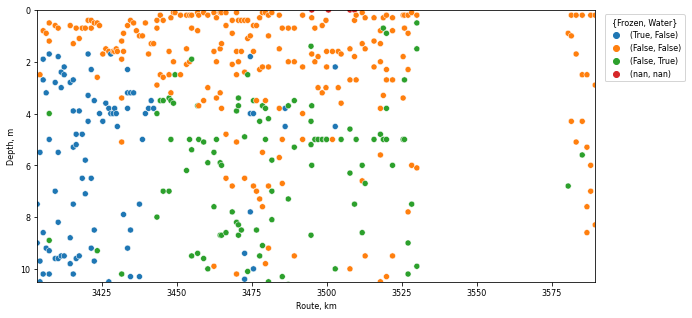

In [131]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x='Route', y='Depth, m',
                hue=df[['Frozen', 'Water']].apply(tuple, axis=1), 
                data=df,
                ax=ax,
                ) 
ax.set_xlim(df.Route.min(), df.Route.max())
ax.set_ylim(0,10.5)
ax.legend(title="{Frozen, Water}", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xlabel("Route, km")
plt.ylabel("Depth, m")
plt.gca().invert_yaxis()

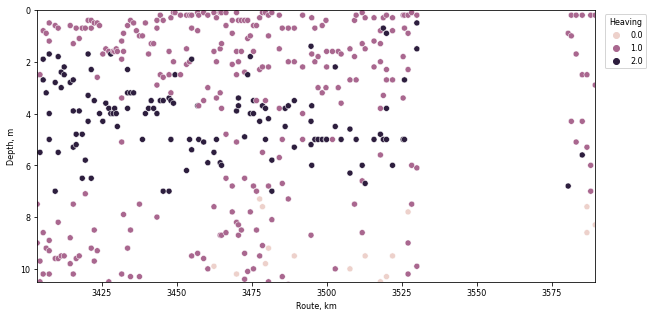

In [132]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x='Route', y='Depth, m',
                hue='Heaving', 
                data=res,
                ax=ax,
                ) 
ax.set_xlim(res.Route.min(), res.Route.max())
ax.set_ylim(0,10.5)
ax.legend(title="Heaving", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xlabel("Route, km")
plt.ylabel("Depth, m")
plt.gca().invert_yaxis()

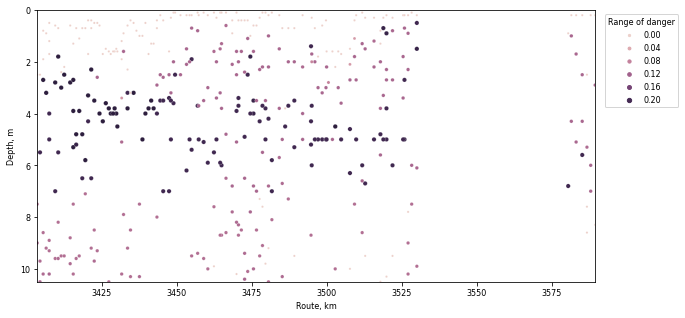

In [133]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x='Route', y='Depth, m',
                hue='Range', 
                size='Range', 
                sizes=(5, 20),
                data=df2,
                ax=ax,
                )
ax.set_xlim(df2.Route.min(), df2.Route.max())
ax.set_ylim(0,10.5)
ax.legend(title='Range of danger',bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xlabel("Route, km")
plt.ylabel("Depth, m")
plt.gca().invert_yaxis()